In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from scipy.stats import expon, reciprocal
from sklearn.metrics import classification_report, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


***
# 1. 데이터셋 살펴보기

- 데이터셋 크기: 2,000,000
- 특성 개수: 34

In [ ]:
# dataset head
df_2017 = pd.read_csv('/content/drive/My Drive/Course/2020년 2학기/헬스케어데이터사이언스(이동호교수님)/pbl/NHIS_2017_2018_100m/NHIS_OPEN_GJ_2017_100.csv', encoding='euc-kr')
df_2018 = pd.read_csv('/content/drive/My Drive/Course/2020년 2학기/헬스케어데이터사이언스(이동호교수님)/pbl/NHIS_2017_2018_100m/NHIS_OPEN_GJ_2018_100.csv', encoding='utf-8')
raw_df = pd.concat([df_2017, df_2018])
print(raw_df.shape)
raw_df.head()

(2000000, 34)


,기준년도,가입자일련번호,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기혈압,이완기혈압,식전혈당(공복혈당),총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치(사랑니)이상,치석,데이터공개일자
0,2017,1,1,8,43,170,75,90.0,1.0,1.0,1.0,1.0,120.0,80.0,99.0,193.0,92.0,48.0,126.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,1.0,1,NaN,NaN,NaN,NaN,1.0,20181126
1,2017,2,1,7,11,180,80,89.0,0.9,1.2,1.0,1.0,130.0,82.0,106.0,228.0,121.0,55.0,148.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,0.0,1,NaN,NaN,NaN,NaN,2.0,20181126
2,2017,3,1,9,41,165,75,91.0,1.2,1.5,1.0,1.0,120.0,70.0,98.0,136.0,104.0,41.0,74.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,20181126
3,2017,4,1,11,48,175,80,91.0,1.5,1.2,1.0,1.0,145.0,87.0,95.0,201.0,106.0,76.0,104.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,0.0,1,NaN,NaN,NaN,NaN,0.0,20181126
4,2017,5,1,11,30,165,60,80.0,1.0,1.2,1.0,1.0,138.0,82.0,101.0,199.0,104.0,61.0,117.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,0.0,1,NaN,NaN,NaN,NaN,0.0,20181126


##### - ~~취소선~~: 반드시 제거할 변수
##### - <u>밑줄</u>: 제거 가능한 변수
##### - <span style="color:blue">파란색</span>: outlier 제거할 변수

### (1) 범주형 변수(16개)
#### - 명목척도(Nominal)
- 1. 성별코드: [1, 2]
- 2. ~~가입자일련번호~~: __중복값은 없음. 일련번호는 매년 랜덤하게 할당__
- 3. 시도코드: __(제주도 잘못 기입된듯 / 기존: 49 ==> 실제: 50)__

#### - 순위척도(Ordinal)
- 4. 청력(좌): [1, 2] <= __Nan값(1750개)__
- 5. 청력(우): [1, 2] <= __Nan값(746개)__
- 6. 흡연상태: [1,2,3] <= __Nan값(756개)__
- 7. 음주여부: [0, 1] <= __Nan값(710,958개)__
- 8. 구강검진수검여부: [0,1]
- 9. <u>치아우식증유무</u>: [0,1] <= __Nan값(3,200,016개)__
- 10. <u>치석</u>: [0,1,2] <= __2, Nan값(44,308개, 2,398,968개)__
- 11. 요단백: [1,2,3,4,5,6] <= __Nan값(30,324개)__
- 12. ~~결손치유무~~: <= __모두 Nan값__
- 13. ~~치아마모증유무~~: <= __모두 Nan값__
- 14. ~~제3대구치(사랑니)이상~~: <= __모두 Nan값__
- 15. ~~기준년도~~: [2017, 2018]
- 16. ~~데이터공개일자~~: [20181126, 20191219]

### (2) <span style="color:black">연속형 변수(17개)</span> 
#### - 등간척도(Interval)
- 1. <span style="color:blue">연령대코드(5세단위)</span>: [5(20~24세) ~ 18(85세+)]
- 2. <span style="color:blue">신장(5Cm단위)</span>: [125 ~ 190]
- 3. <span style="color:blue">체중(5Kg단위)</span>: [25 ~ 140]

#### - 비율척도(Ratio)
- 4. <span style="color:blue">허리둘레(cm)</span>: 1 ~ 999 <= __Nan값(1,360개)__
- 5. <span style="color:blue">시력(좌)</span>: .1 ~ 9.9 <= __Nan값(872개)__
- 6. <span style="color:blue">시력(우)</span>: .1 ~ 9.9 <= __Nan값(910개)__
- 7. <span style="color:blue">수축기 혈압(mmHg)</span>: 58 ~ 273 <= __Nan값(11,498개)__
- 8. <span style="color:blue">이완기 혈압(mmHg)</span>: 27 ~ 185 <= __Nan값(11,496개)__
- 9. <span style="color:blue"><u>총콜레스테롤(mg/dL)</u></span>: 6 ~ 2386 <= __Nan값(1,334,574개)__
- 10. <span style="color:blue"><u>트리글리세라이드(mg/dL)</u></span>: 1 ~ 9490 <= __Nan값(1,334,594개)__
- 11. <span style="color:blue"><u>HDL 콜레스테롤(mg/dL)</u></span>: 1 ~ 8110 <= __Nan값(1,334,596개)__
- 12. <span style="color:blue"><u>LDL 콜레스테롤(mg/dL)</u></span>: 1 ~ 5119 <= __Nan값(1,354,068개)__
- 13. <span style="color:blue">혈색소(g/dL)</span>: .5 ~ 25 <= __Nan값(11,932개)__
- 14. <span style="color:blue">혈청크레아티닌(mg/dL)</span>: .1 ~ 98 <= __Nan값(11,898개)__
- 15. <span style="color:blue">(혈청지오티)AST(mg/dL)</span>: 1 ~ 9999 <= __Nan값(11,894개)__
- 16. <span style="color:blue">(혈청지오티)ALT(mg/dL)</span>: 2 ~ 7210 <= __Nan값(11,896개)__
- 17. <span style="color:blue">감마지티피(U/L)</span>: 1 ~ 999 <= __Nan값(11,902개)__




### (3) <span style="color:red">타겟변수</span> 
- <span style="color:blue">식전혈당(공복혈당)(mg/dL)</span>: 23 ~ 872 <= __Nan값(11,914개)__

In [ ]:
# summarize dataset
raw_df.iloc[:, :17].describe()

,기준년도,가입자일련번호,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기혈압,이완기혈압,식전혈당(공복혈당),총콜레스테롤,트리글리세라이드
count,2000000.0,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,1.999320e+06,1.999564e+06,1.999545e+06,1.999625e+06,1.999627e+06,1.994251e+06,1.994252e+06,1.994043e+06,1.332713e+06,1.332703e+06
mean,2017.5,5.000005e+05,1.466995e+00,1.056190e+01,3.369548e+01,1.622604e+02,6.342898e+01,8.134754e+01,9.786358e-01,9.762449e-01,1.032698e+00,1.031518e+00,1.225481e+02,7.606142e+01,1.006600e+02,1.956388e+02,1.335479e+02
std,0.5,2.886752e+05,4.989096e-01,2.860501e+00,1.267530e+01,9.310089e+00,1.262693e+01,1.106285e+01,6.073918e-01,6.047442e-01,1.778441e-01,1.747127e-01,1.459186e+01,9.954033e+00,2.418251e+01,3.918748e+01,1.038458e+02
min,2017.0,1.000000e+00,1.000000e+00,5.000000e+00,1.100000e+01,1.250000e+02,2.500000e+01,1.000000e+00,1.000000e-01,1.000000e-01,1.000000e+00,1.000000e+00,5.800000e+01,2.700000e+01,2.300000e+01,6.000000e+00,1.000000e+00
25%,2017.0,2.500008e+05,1.000000e+00,8.000000e+00,2.700000e+01,1.550000e+02,5.500000e+01,7.450000e+01,7.000000e-01,7.000000e-01,1.000000e+00,1.000000e+00,1.120000e+02,7.000000e+01,8.900000e+01,1.690000e+02,7.400000e+01
50%,2017.5,5.000005e+05,1.000000e+00,1.100000e+01,4.100000e+01,1.600000e+02,6.000000e+01,8.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.210000e+02,7.600000e+01,9.600000e+01,1.930000e+02,1.080000e+02
75%,2018.0,7.500002e+05,2.000000e+00,1.300000e+01,4.300000e+01,1.700000e+02,7.000000e+01,8.800000e+01,1.200000e+00,1.200000e+00,1.000000e+00,1.000000e+00,1.310000e+02,8.200000e+01,1.050000e+02,2.200000e+02,1.600000e+02
max,2018.0,1.000000e+06,2.000000e+00,1.800000e+01,5.000000e+01,1.900000e+02,1.400000e+02,9.990000e+02,9.900000e+00,9.900000e+00,2.000000e+00,2.000000e+00,2.730000e+02,1.850000e+02,8.720000e+02,2.386000e+03,9.490000e+03


In [ ]:
# summarize dataset
raw_df.iloc[:, 17:].describe()

,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치(사랑니)이상,치석,데이터공개일자
count,1.332702e+06,1.322966e+06,1.994034e+06,1.984838e+06,1.994051e+06,1.994053e+06,1.994052e+06,1.994049e+06,1.999622e+06,1.644521e+06,2.000000e+06,399992.000000,0.0,0.0,0.0,800516.000000,2.000000e+06
mean,5.680952e+01,1.131066e+02,1.425832e+01,1.095813e+00,8.633026e-01,2.614770e+01,2.601790e+01,3.739504e+01,1.607232e+00,6.956865e-01,4.002580e-01,0.215164,NaN,NaN,NaN,0.603340,2.018617e+07
std,1.929372e+01,3.656292e+01,1.583889e+00,4.390614e-01,4.986576e-01,2.501259e+01,2.678962e+01,5.061595e+01,8.176123e-01,4.601162e-01,4.899507e-01,0.410937,NaN,NaN,NaN,0.591625,5.046501e+03
min,1.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00,1.000000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,NaN,0.000000,2.018113e+07
25%,4.600000e+01,8.900000e+01,1.320000e+01,1.000000e+00,7.000000e-01,1.900000e+01,1.500000e+01,1.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,NaN,0.000000,2.018113e+07
50%,5.500000e+01,1.110000e+02,1.430000e+01,1.000000e+00,8.000000e-01,2.300000e+01,2.000000e+01,2.300000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000,NaN,NaN,NaN,1.000000,2.018617e+07
75%,6.500000e+01,1.350000e+02,1.540000e+01,1.000000e+00,1.000000e+00,2.900000e+01,3.000000e+01,4.000000e+01,2.000000e+00,1.000000e+00,1.000000e+00,0.000000,NaN,NaN,NaN,1.000000,2.019122e+07
max,8.110000e+03,5.119000e+03,2.500000e+01,6.000000e+00,9.800000e+01,9.999000e+03,7.210000e+03,9.990000e+02,3.000000e+00,1.000000e+00,1.000000e+00,1.000000,NaN,NaN,NaN,2.000000,2.019122e+07


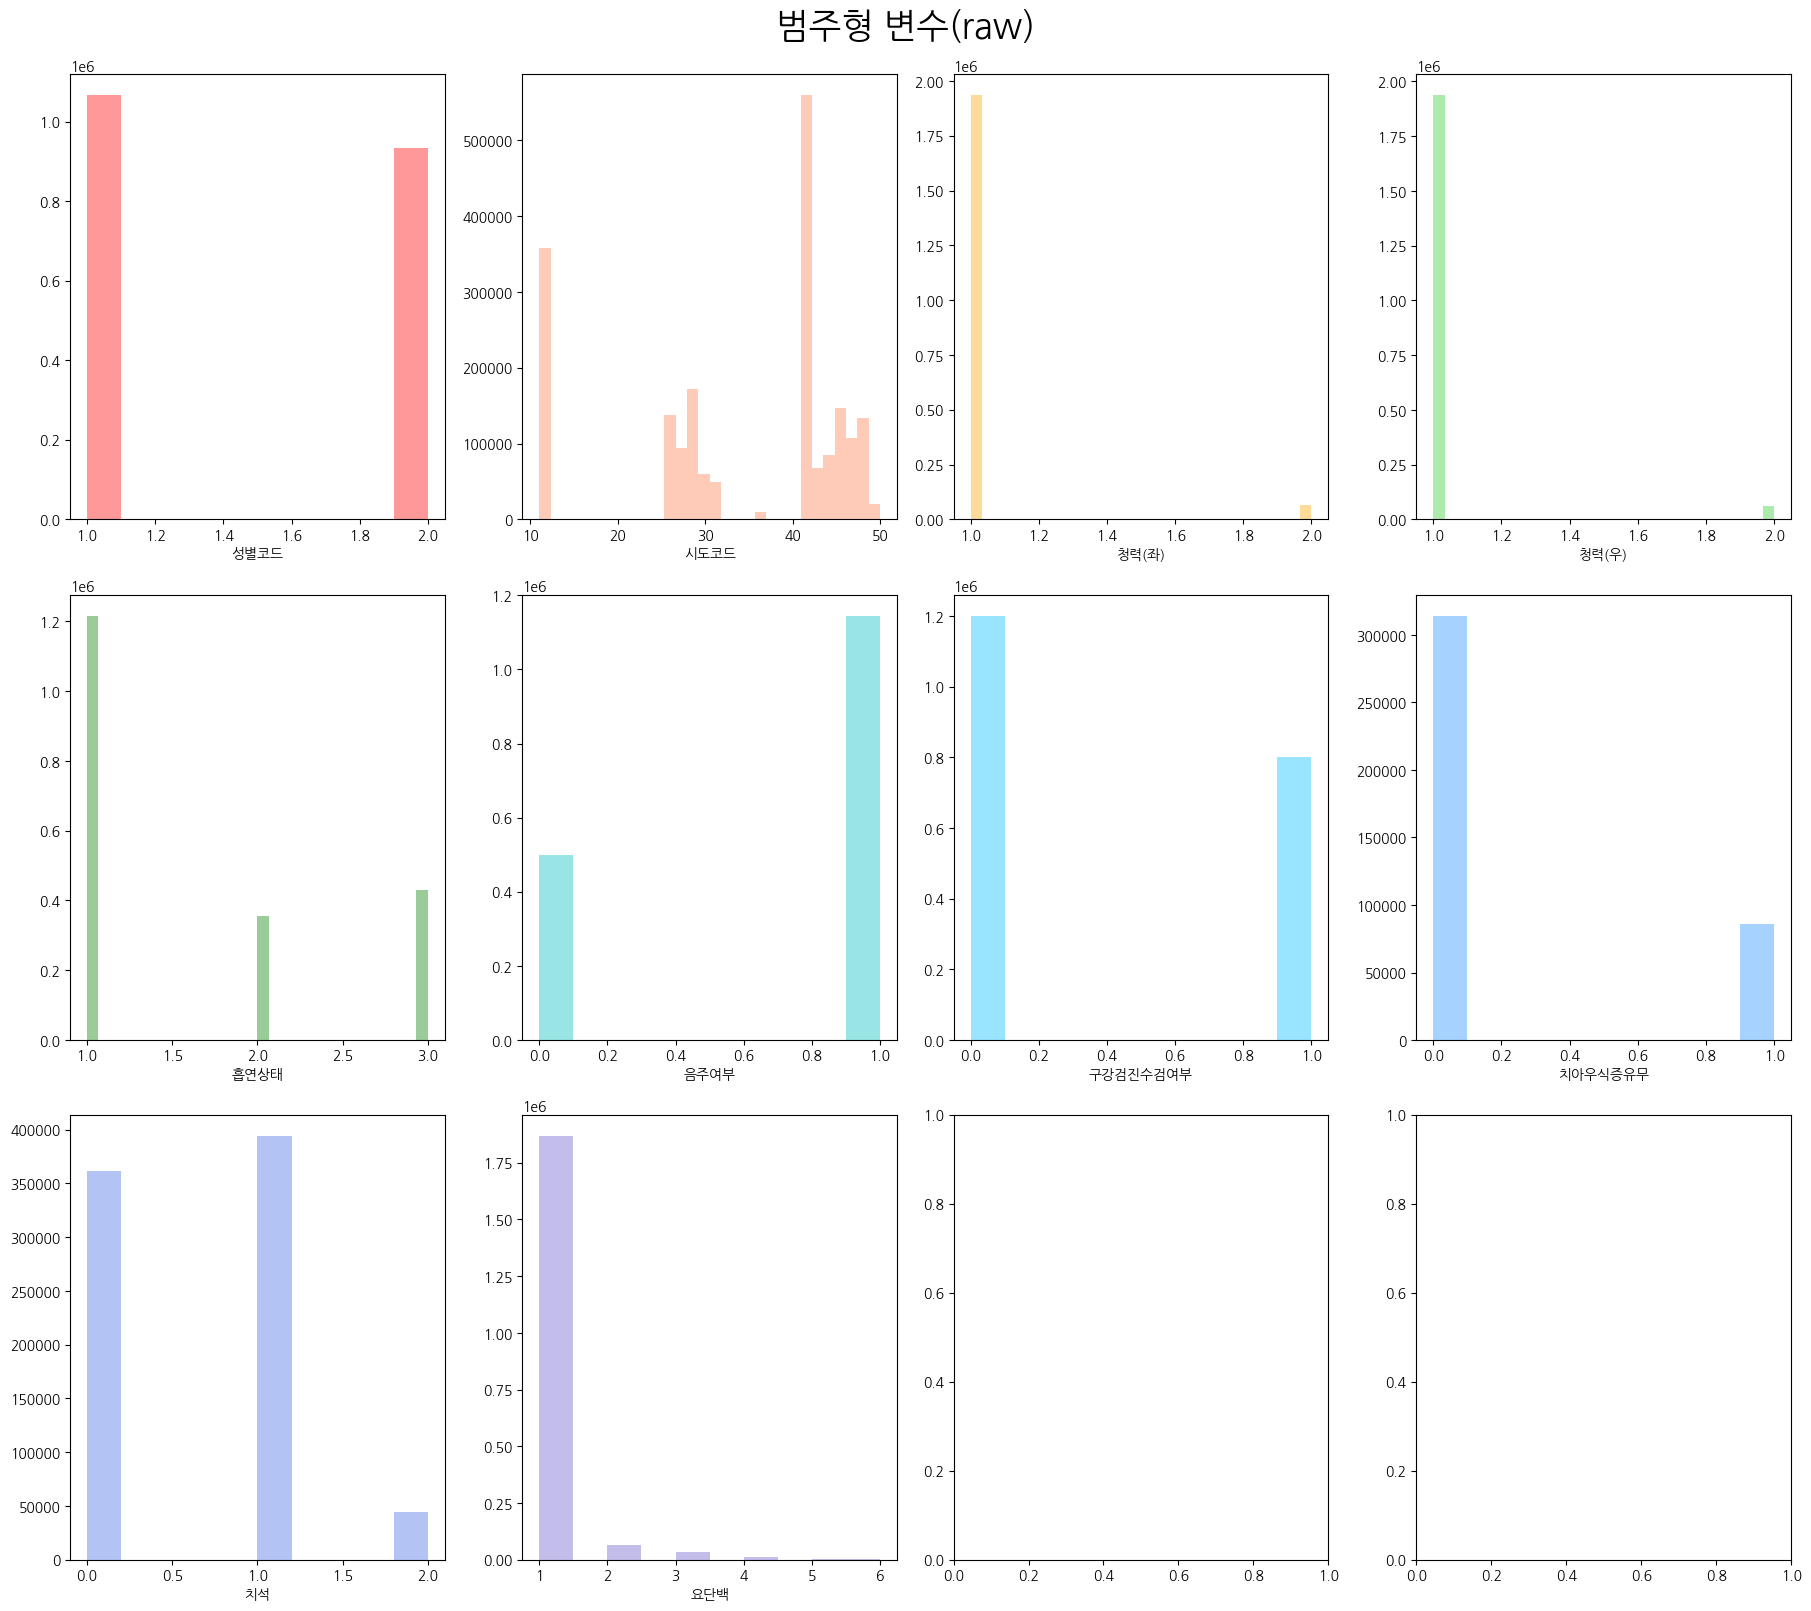

<Figure size 640x480 with 0 Axes>

In [ ]:
# plots for categorical features 
sns.reset_defaults()
plt.rcParams['font.family'] = 'NanumGothic'
f, axes = plt.subplots(3,4,figsize=(18,16), constrained_layout=True)
sns.distplot(raw_df["성별코드"], color='red', ax=axes[0,0], hist=True, kde=False, bins=10)
sns.distplot(raw_df["시도코드"], color='coral', ax=axes[0,1], hist=True, kde=False, bins=30)
sns.distplot(raw_df["청력(좌)"], color='orange', ax=axes[0,2], hist=True, kde=False, bins=30)
sns.distplot(raw_df["청력(우)"], color='limegreen', ax=axes[0,3], hist=True, kde=False, bins=30)
sns.distplot(raw_df["흡연상태"], color='green', ax=axes[1,0], hist=True, kde=False, bins=30)
sns.distplot(raw_df["음주여부"], color='c', ax=axes[1,1], hist=True, kde=False, bins=10)
sns.distplot(raw_df["구강검진수검여부"], color='deepskyblue', ax=axes[1,2], hist=True, kde=False, bins=10)
sns.distplot(raw_df["치아우식증유무"], color='dodgerblue', ax=axes[1,3], hist=True, kde=False, bins=10)
sns.distplot(raw_df["치석"], color='royalblue', ax=axes[2,0], hist=True, kde=False, bins=10)
sns.distplot(raw_df["요단백"], color='slateblue', ax=axes[2,1], hist=True, kde=False, bins=10)
f.suptitle('범주형 변수(raw)', fontsize=25)
plt.show()
plt.clf()

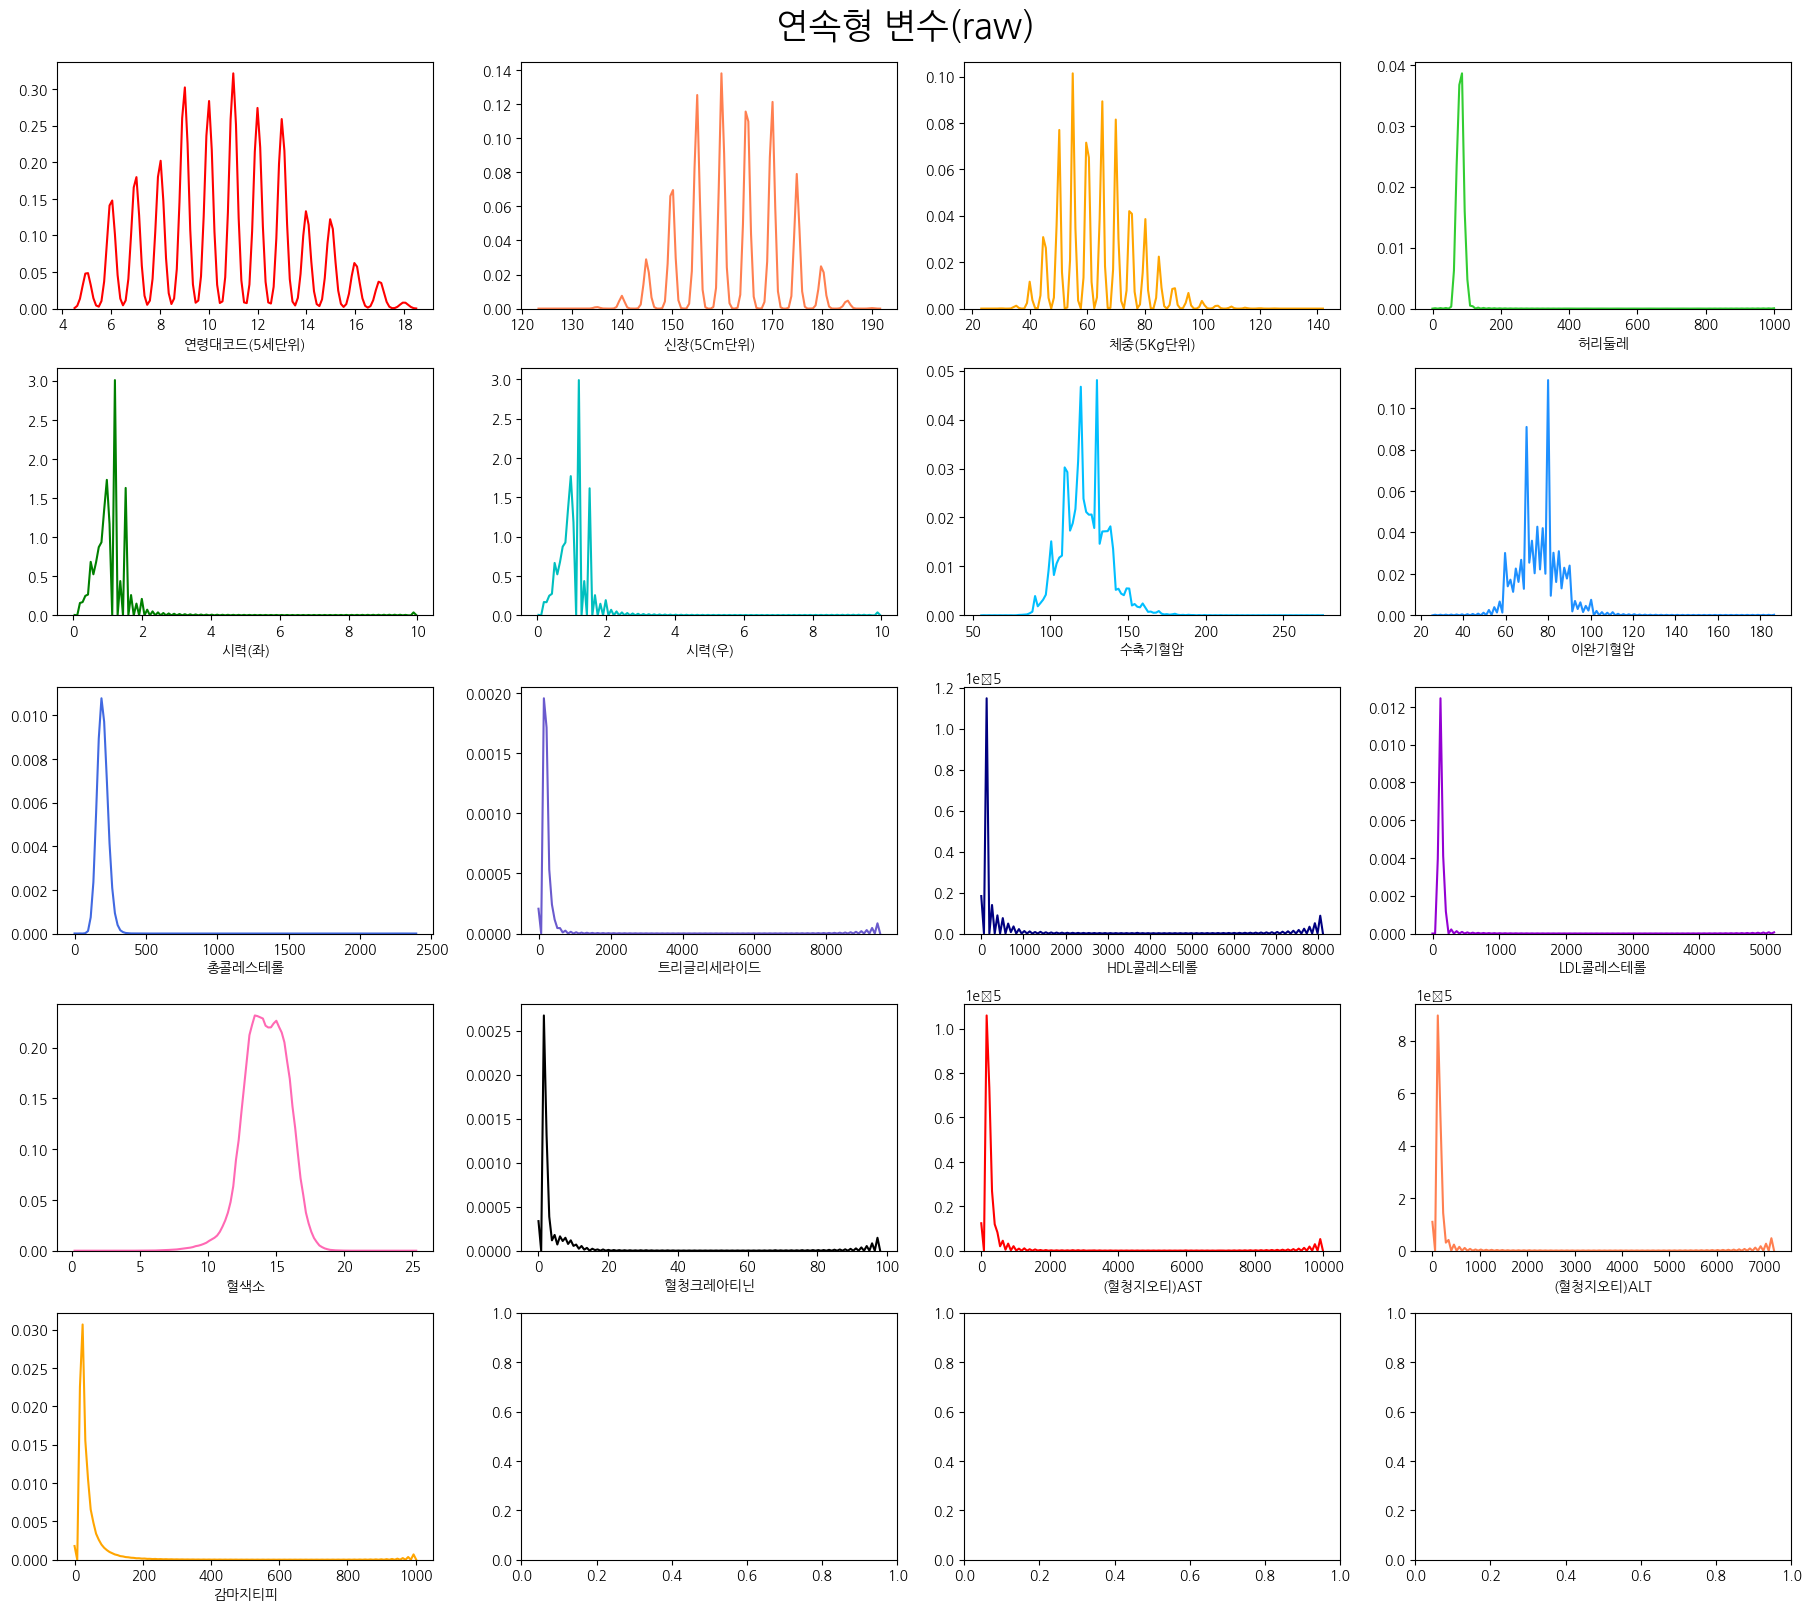

In [ ]:
# plots for categorical features 
sns.reset_defaults()
plt.rcParams['font.family'] = 'NanumGothic'
f, axes = plt.subplots(5,4,figsize=(18,16), constrained_layout=True)
sns.distplot(raw_df["연령대코드(5세단위)"], color='red', ax=axes[0,0], hist=False, kde=True, bins=30)
sns.distplot(raw_df["신장(5Cm단위)"], color='coral', ax=axes[0,1], hist=False, kde=True, bins=30)
sns.distplot(raw_df["체중(5Kg단위)"], color='orange', ax=axes[0,2], hist=False, kde=True, bins=30)
sns.distplot(raw_df["허리둘레"], color='limegreen', ax=axes[0,3], hist=False, kde=True, bins=30)
sns.distplot(raw_df["시력(좌)"], color='green', ax=axes[1,0], hist=False, kde=True, bins=10)
sns.distplot(raw_df["시력(우)"], color='c', ax=axes[1,1], hist=False, kde=True, bins=10)
sns.distplot(raw_df["수축기혈압"], color='deepskyblue', ax=axes[1,2], hist=False, kde=True, bins=30)
sns.distplot(raw_df["이완기혈압"], color='dodgerblue', ax=axes[1,3], hist=False, kde=True, bins=30)
sns.distplot(raw_df["총콜레스테롤"], color='royalblue', ax=axes[2,0], hist=False, kde=True, bins=10)
sns.distplot(raw_df["트리글리세라이드"], color='slateblue', ax=axes[2,1], hist=False, kde=True, bins=10)
sns.distplot(raw_df["HDL콜레스테롤"], color='navy', ax=axes[2,2], hist=False, kde=True, bins=10)
sns.distplot(raw_df["LDL콜레스테롤"], color='darkviolet', ax=axes[2,3], hist=False, kde=True, bins=10)
sns.distplot(raw_df["혈색소"], color='hotpink', ax=axes[3,0], hist=False, kde=True, bins=10)
sns.distplot(raw_df["혈청크레아티닌"], color='black', ax=axes[3,1], hist=False, kde=True, bins=10)
sns.distplot(raw_df["(혈청지오티)AST"], color='red', ax=axes[3,2], hist=False, kde=True, bins=10)
sns.distplot(raw_df["(혈청지오티)ALT"], color='coral', ax=axes[3,3], hist=False, kde=True, bins=10)
sns.distplot(raw_df["감마지티피"], color='orange', ax=axes[4,0], hist=False, kde=True, bins=10)
f.suptitle('연속형 변수(raw)', fontsize=25)
plt.show()
plt.clf()

In [ ]:
f, axes = plt.subplots(1,4,figsize=(6,4), constrained_layout=True)
boxplot = raw_df.boxplot(by=['수축기혈압'])
plt.show()

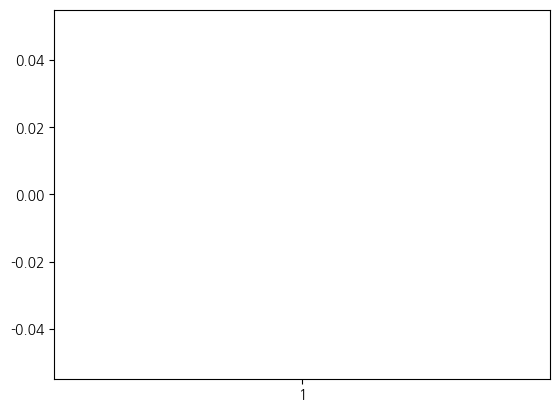

In [ ]:
sns.reset_defaults()
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(1)
plt.boxplot(raw_df['수축기혈압'])
plt.show()
plt.clf()

In [ ]:
# plots for categorical features 
sns.reset_defaults()
plt.rcParams['font.family'] = 'NanumGothic'
f, axes = plt.subplots(1,4,figsize=(6,4), constrained_layout=True)
sns.boxplot(data = raw_df["수축기혈압"], color='red', ax=axes[0])
sns.boxplot(data = raw_df["트리글리세라이드"], color='coral', ax=axes[1])
sns.boxplot(data = raw_df["혈청크레아티닌"], color='orange', ax=axes[2])
sns.boxplot(data = raw_df["감마지티피"], color='limegreen', ax=axes[3])
plt.show()
plt.clf()

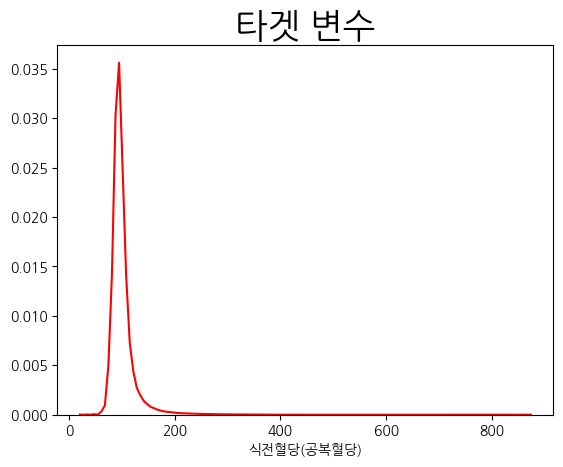

<Figure size 640x480 with 0 Axes>

In [ ]:
sns.reset_defaults()
plt.rcParams['font.family'] = 'NanumGothic'
sns.distplot(raw_df["식전혈당(공복혈당)"], color='red', hist=False, kde=True, bins=10).set_title('타겟 변수', fontsize=25)
plt.show()
plt.clf()

In [ ]:
for column in raw_df.columns:
    if raw_df[column].isnull().any():
        index = raw_df[column].index[raw_df[column].apply(np.isnan)]
        print(f'The number of Nan values for {column}: ', len(raw_df.loc[index]) )

The number of Nan values for 허리둘레:  1360
The number of Nan values for 시력(좌):  872
The number of Nan values for 시력(우):  910
The number of Nan values for 청력(좌):  750
The number of Nan values for 청력(우):  746
The number of Nan values for 수축기혈압:  11498
The number of Nan values for 이완기혈압:  11496
The number of Nan values for 식전혈당(공복혈당):  11914
The number of Nan values for 총콜레스테롤:  1334574
The number of Nan values for 트리글리세라이드:  1334594
The number of Nan values for HDL콜레스테롤:  1334596
The number of Nan values for LDL콜레스테롤:  1354068
The number of Nan values for 혈색소:  11932
The number of Nan values for 요단백:  30324
The number of Nan values for 혈청크레아티닌:  11898
The number of Nan values for (혈청지오티)AST:  11894
The number of Nan values for (혈청지오티)ALT:  11896
The number of Nan values for 감마지티피:  11902
The number of Nan values for 흡연상태:  756
The number of Nan values for 음주여부:  710958
The number of Nan values for 치아우식증유무:  3200016
The number of Nan values for 결손치유무:  4000000
The number of Nan values for 치

***
# 2. 테스트 세트 만들기

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(raw_df, test_size = .2, random_state=42)
df = train_set.copy()

***
# 3. 데이터 정제

#### Step 1. 변수 제거
- 분석에 불필요한 변수: ['기준년도, '가입자일련번호', '데이터공개일자']
- 변수값이 존재하지 않는 변수 : ['결손치유무', '치아마모증유무', '제3대구치(사랑니)이상']

#### Step 2. 시스템적 오류값(error value) 처리
- 연령대코드(5세단위)는 40세 이상부터 고려
- 치석 변수의 2는 정의되지 않은 값

#### Step 4. 결측값(missing value) 처리
- 범주형 변수는 평균값
- 연속형 변주는 보간법

#### Step 3. 이상치(outlier) 제거
- 변수: ['연령대코드(5세단위)', '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레', '시력 좌우', '혈압(수축기/이완기)', '혈색소', '콜레스테롤(총, HDL, LDL)', <br>'트리글리세라이드', '혈청크레아티닌', '혈청지오티(AST, ALT)', '감마지티피']</br>
- 이상치 정의 중 IQR 방식을 활용

#### Step 5. 활용가능한 변수 추가
- 기존 데이터 변수에서 당뇨와 관련된 새로운 변수 도출이 가능한 경우에 변수 추가
- 추가한 변수: BMI(=체중 / 신장^2), 수도권([서울, 경기] = 1 / [그 외] = 0)

In [ ]:
# drop features
df = df.drop(columns=['기준년도', '가입자일련번호', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '데이터공개일자']) 

# handle error value
df = df[df['연령대코드(5세단위)'] > 8] # remove age under 40
df = df[df['치석'] != 2] # remove value 2 in '치석'

# handle missing categorical features
df = df.fillna(df.mean()[['청력(좌)', '청력(우)','흡연상태', '음주여부', '치아우식증유무', '치석', '요단백']])

# handle missing continuous features
df = df.interpolate()
df = df.reset_index(drop=True)

# drop outliers
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

outlier_columns = ['연령대코드(5세단위)', '신장(5Cm단위)', '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)', '수축기혈압', '이완기혈압', '혈색소', 
                   '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤']
for column in outlier_columns:
    df = remove_outlier(df, column)

# append new columns
df['BMI'] = df['체중(5Kg단위)'] / (df['신장(5Cm단위)'] ** 2)
df.loc[(df['시도코드'] == 11) ^ (df['시도코드'] == 41), '수도권'] = 1 
df.loc[(df['시도코드'] != 11) & (df['시도코드'] != 41), '수도권'] = 0 

print('shape of dataset: ', df.shape)

shape of dataset:  (542273, 30)


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


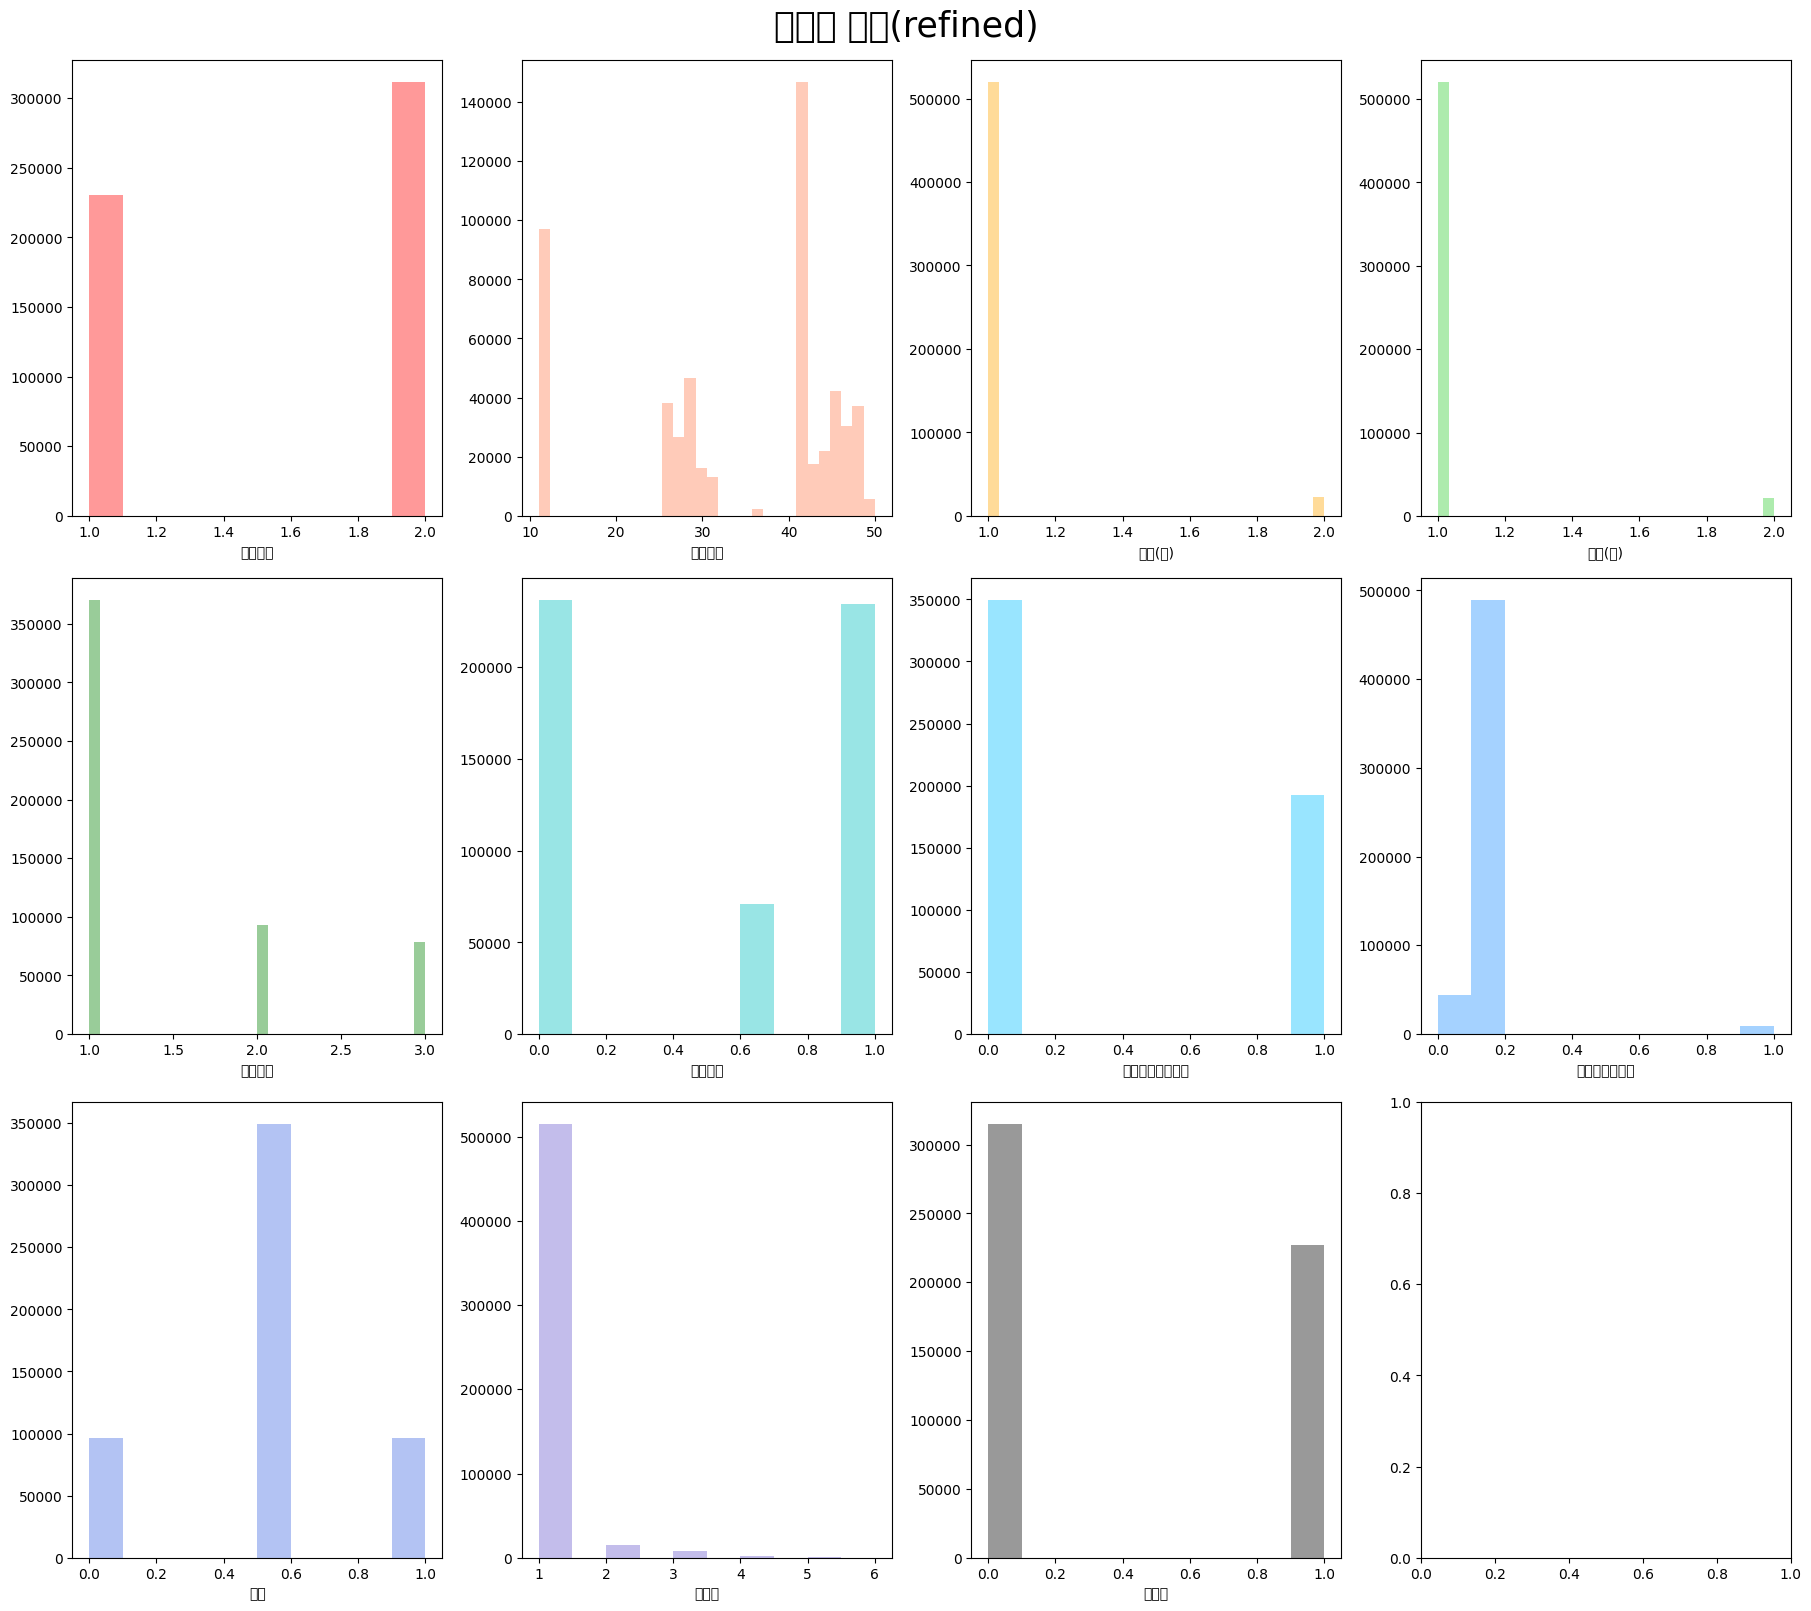

In [ ]:
# plots for categorical features 
sns.reset_defaults()
plt.rcParams['font.family'] = 'NanumGothic'
f, axes = plt.subplots(3,4,figsize=(18,16), constrained_layout=True)
sns.distplot(df["성별코드"], color='red', ax=axes[0,0], hist=True, kde=False, bins=10)
sns.distplot(df["시도코드"], color='coral', ax=axes[0,1], hist=True, kde=False, bins=30)
sns.distplot(df["청력(좌)"], color='orange', ax=axes[0,2], hist=True, kde=False, bins=30)
sns.distplot(df["청력(우)"], color='limegreen', ax=axes[0,3], hist=True, kde=False, bins=30)
sns.distplot(df["흡연상태"], color='green', ax=axes[1,0], hist=True, kde=False, bins=30)
sns.distplot(df["음주여부"], color='c', ax=axes[1,1], hist=True, kde=False, bins=10)
sns.distplot(df["구강검진수검여부"], color='deepskyblue', ax=axes[1,2], hist=True, kde=False, bins=10)
sns.distplot(df["치아우식증유무"], color='dodgerblue', ax=axes[1,3], hist=True, kde=False, bins=10)
sns.distplot(df["치석"], color='royalblue', ax=axes[2,0], hist=True, kde=False, bins=10)
sns.distplot(df["요단백"], color='slateblue', ax=axes[2,1], hist=True, kde=False, bins=10)
sns.distplot(df["수도권"], color='black', ax=axes[2,2], hist=True, kde=False, bins=10)
f.suptitle('범주형 변수(refined)', fontsize=25)
plt.show()
plt.clf()

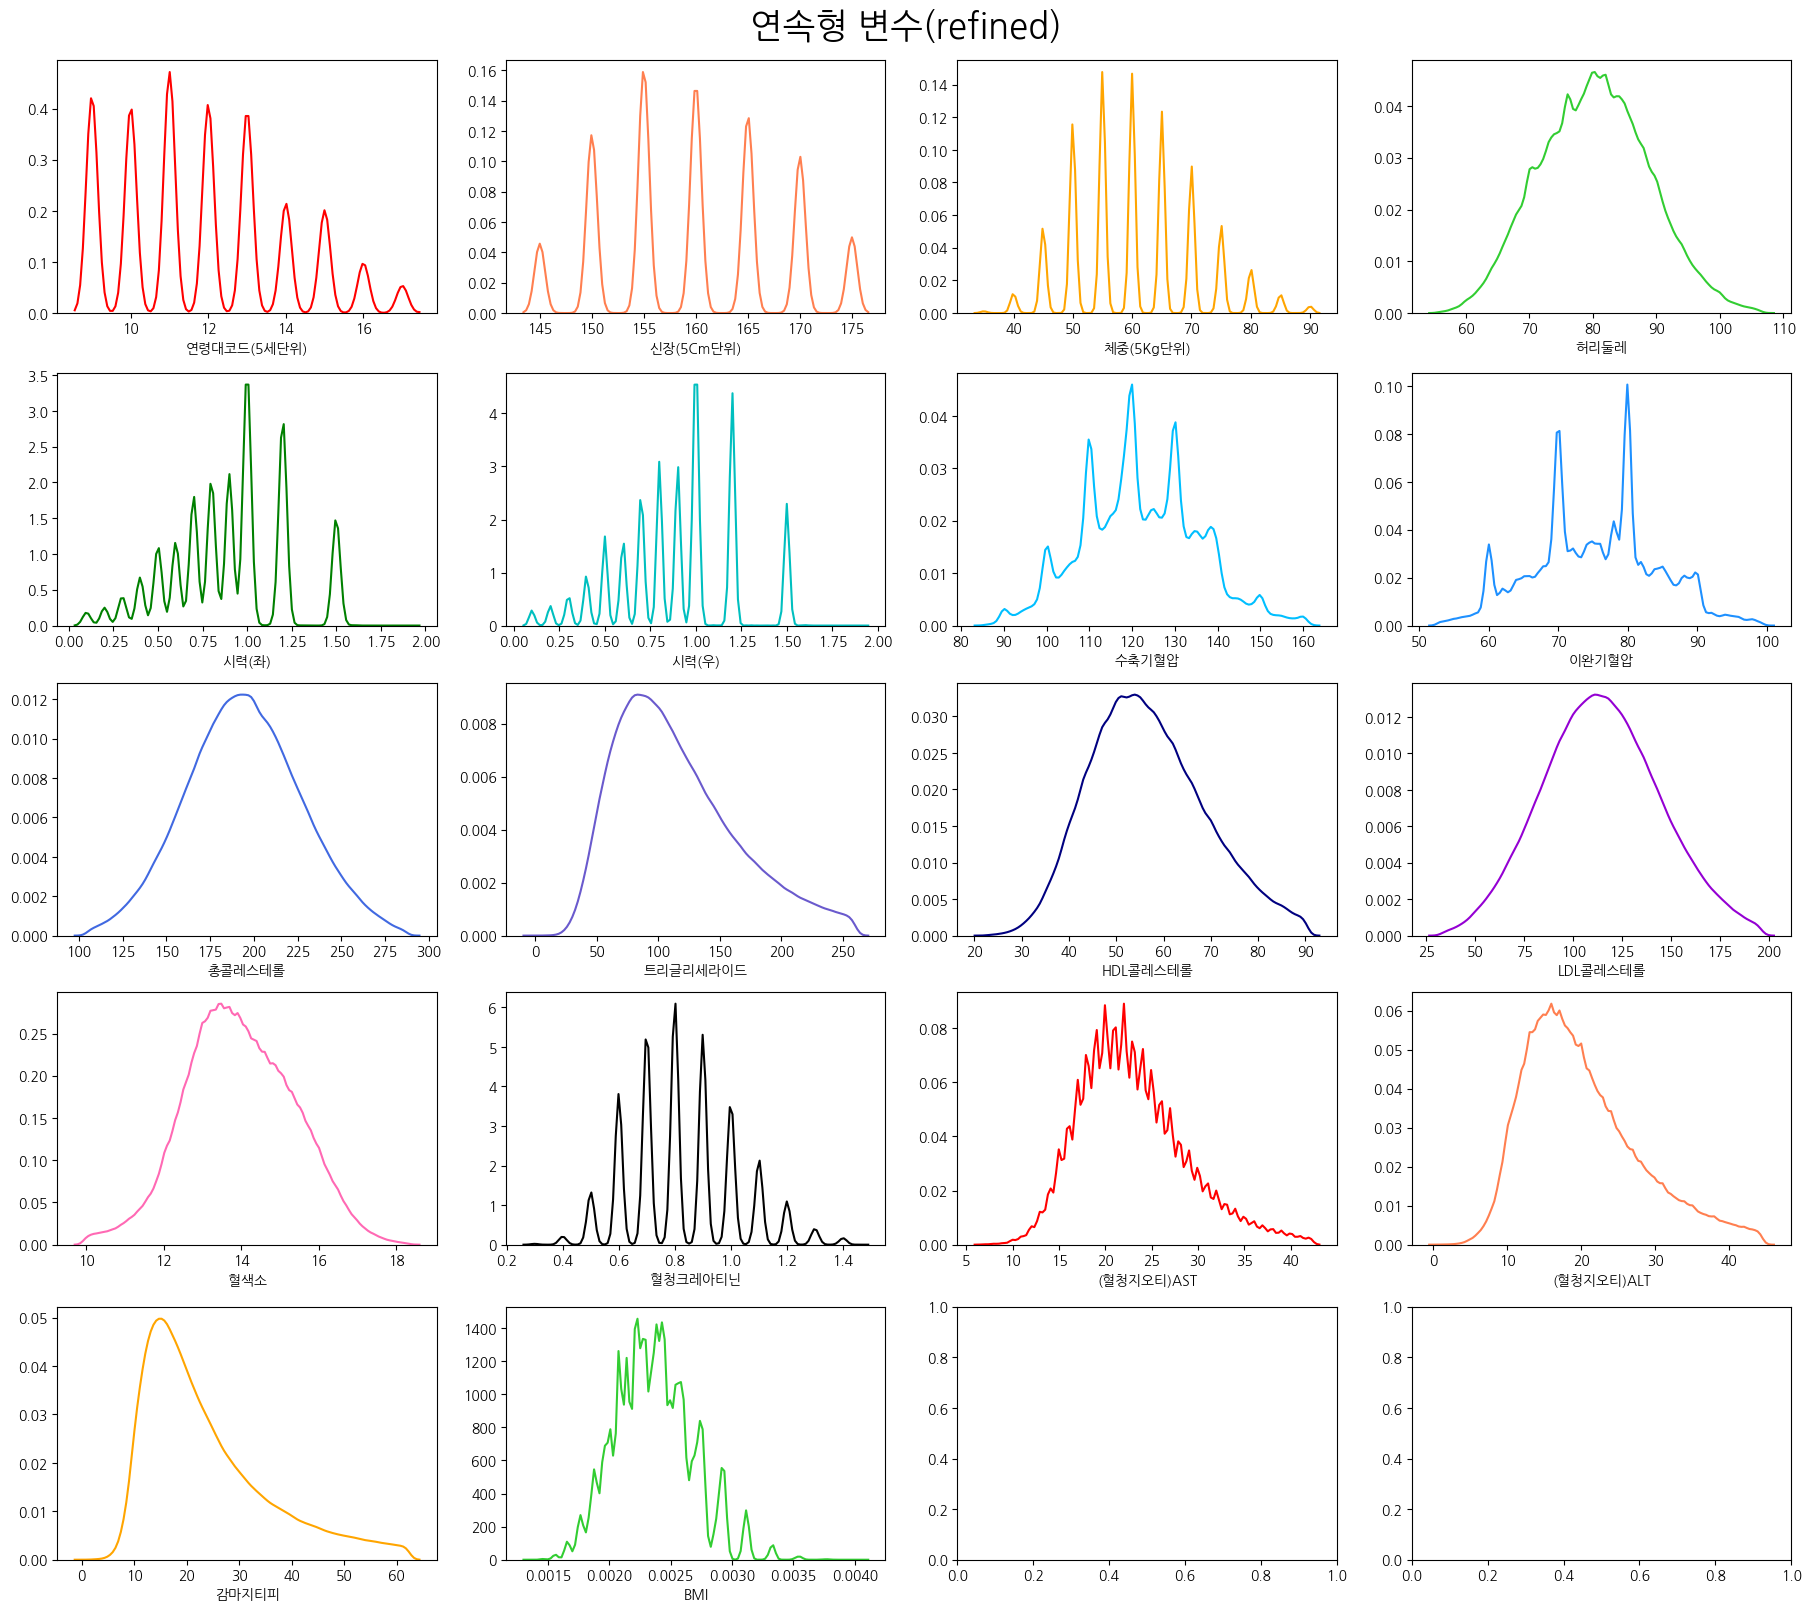

<Figure size 640x480 with 0 Axes>

In [ ]:
# plots for categorical features 
sns.reset_defaults()
plt.rcParams['font.family'] = 'NanumGothic'
f, axes = plt.subplots(5,4,figsize=(18,16), constrained_layout=True)
sns.distplot(df["연령대코드(5세단위)"], color='red', ax=axes[0,0], hist=False, kde=True, bins=30)
sns.distplot(df["신장(5Cm단위)"], color='coral', ax=axes[0,1], hist=False, kde=True, bins=30)
sns.distplot(df["체중(5Kg단위)"], color='orange', ax=axes[0,2], hist=False, kde=True, bins=30)
sns.distplot(df["허리둘레"], color='limegreen', ax=axes[0,3], hist=False, kde=True, bins=30)
sns.distplot(df["시력(좌)"], color='green', ax=axes[1,0], hist=False, kde=True, bins=10)
sns.distplot(df["시력(우)"], color='c', ax=axes[1,1], hist=False, kde=True, bins=10)
sns.distplot(df["수축기혈압"], color='deepskyblue', ax=axes[1,2], hist=False, kde=True, bins=30)
sns.distplot(df["이완기혈압"], color='dodgerblue', ax=axes[1,3], hist=False, kde=True, bins=30)
sns.distplot(df["총콜레스테롤"], color='royalblue', ax=axes[2,0], hist=False, kde=True, bins=10)
sns.distplot(df["트리글리세라이드"], color='slateblue', ax=axes[2,1], hist=False, kde=True, bins=10)
sns.distplot(df["HDL콜레스테롤"], color='navy', ax=axes[2,2], hist=False, kde=True, bins=10)
sns.distplot(df["LDL콜레스테롤"], color='darkviolet', ax=axes[2,3], hist=False, kde=True, bins=10)
sns.distplot(df["혈색소"], color='hotpink', ax=axes[3,0], hist=False, kde=True, bins=10)
sns.distplot(df["혈청크레아티닌"], color='black', ax=axes[3,1], hist=False, kde=True, bins=10)
sns.distplot(df["(혈청지오티)AST"], color='red', ax=axes[3,2], hist=False, kde=True, bins=10)
sns.distplot(df["(혈청지오티)ALT"], color='coral', ax=axes[3,3], hist=False, kde=True, bins=10)
sns.distplot(df["감마지티피"], color='orange', ax=axes[4,0], hist=False, kde=True, bins=10)
sns.distplot(df["BMI"], color='limegreen', ax=axes[4,1], hist=False, kde=True, bins=10)
f.suptitle('연속형 변수(refined)', fontsize=25)
plt.show()
plt.clf()

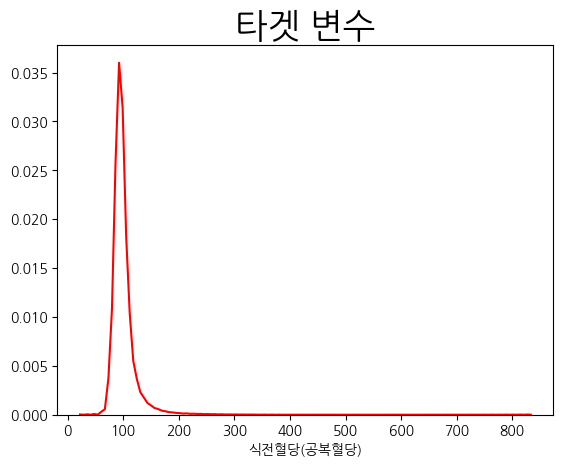

<Figure size 640x480 with 0 Axes>

In [ ]:
sns.reset_defaults()
plt.rcParams['font.family'] = 'NanumGothic'
sns.distplot(df["식전혈당(공복혈당)"], color='red', hist=False, kde=True, bins=10).set_title('타겟 변수', fontsize=25)
plt.show()
plt.clf()

***
# 4. 분석 결과
- 선형회귀를 활용하여 '식전혈당(공복혈당)'과 변수들 간 상관관계 파악
- 다중공선성(VIF)은 10 이하
- p-value는 .05 이하

<center><img src="./linear_coef_table.png" width="50%" height="50%"></center>

In [ ]:
#X = merge_df.drop(columns=['식전혈당(공복혈당)'])
X = df.drop(columns=['식전혈당(공복혈당)', 'HDL콜레스테롤', 'LDL콜레스테롤', '총콜레스테롤', '체중(5Kg단위)', '이완기혈압', '시도코드' ,'(혈청지오티)AST', '청력(우)'])
X = sm.add_constant(X)
y = df[['식전혈당(공복혈당)']]
model = sm.OLS(y, X, hasconst=True).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             식전혈당(공복혈당)   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2281.
Date:                Mon, 26 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:43:22   Log-Likelihood:            -2.4183e+06
No. Observations:              542273   AIC:                         4.837e+06
Df Residuals:                  542251   BIC:                         4.837e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          48.8839      1.255     38.955      0.000      46.424      51.343
성별코드           -0.9163      0.117     -7.831      0.000      -1.146      -0.687
연령대코드(5세단위)     0.9485      0.018     52.815      0.000       0.913       0.984
신장(5Cm단위)       0.0019      0.006      0.316      0.752      -0.010       0.013
허리둘레            0.1986      0.006     32.187      0.000       0.186       0.211
시력(좌)          -1.3157      0.127    -10.365      0.000      -1.564      -1.067
시력(우)          -1.4523      0.127    -11.425      0.000      -1.701      -1.203
청력(좌)           0.0143      0.147      0.097      0.923      -0.274       0.303
수축기혈압           0.1027      0.002     44.515      0.000       0.098       0.107
트리글리세라이드        0.0343      0.001     54.935      0.000       0.033       0.035
혈색소             0.1006      0.028      3.598      0.000       0.046       0.155
요단백             3.8148      0.074     51.871      0.000       3.671       3.959
혈청크레아티닌         0.0057      0.187      0.030      0.976      -0.361       0.372
(혈청지오티)ALT      0.1060      0.004     24.979      0.000       0.098       0.114
감마지티피           0.1278      0.003     43.180      0.000       0.122       0.134
흡연상태            0.3535      0.051      6.995      0.000       0.254       0.453
음주여부            0.1126      0.067      1.678      0.093      -0.019       0.244
구강검진수검여부       -0.4645      0.060     -7.747      0.000      -0.582      -0.347
치아우식증유무        -0.3247      0.244     -1.332      0.183      -0.802       0.153
치석              0.2268      0.096      2.363      0.018       0.039       0.415
BMI           254.4266    154.171      1.650      0.099     -47.744     556.597
수도권            -0.7364      0.058    -12.738      0.000      -0.850      -0.623
==============================================================================
Omnibus:                   511100.019   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         38847588.210
Skew:                           4.391   Prob(JB):                         0.00
Kurtosis:                      43.524   Cond. No.                     1.34e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
variables = model.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif_df = pd.DataFrame({'feature': X.columns.to_list(), 'vif': vif})
vif_df

,feature,vif
0,const,1950.888793
1,성별코드,4.131312
2,연령대코드(5세단위),1.804879
3,신장(5Cm단위),2.831232
4,허리둘레,3.439566
5,시력(좌),1.989327
6,시력(우),1.985998
7,청력(좌),1.048056
8,수축기혈압,1.186761
9,트리글리세라이드,1.077128


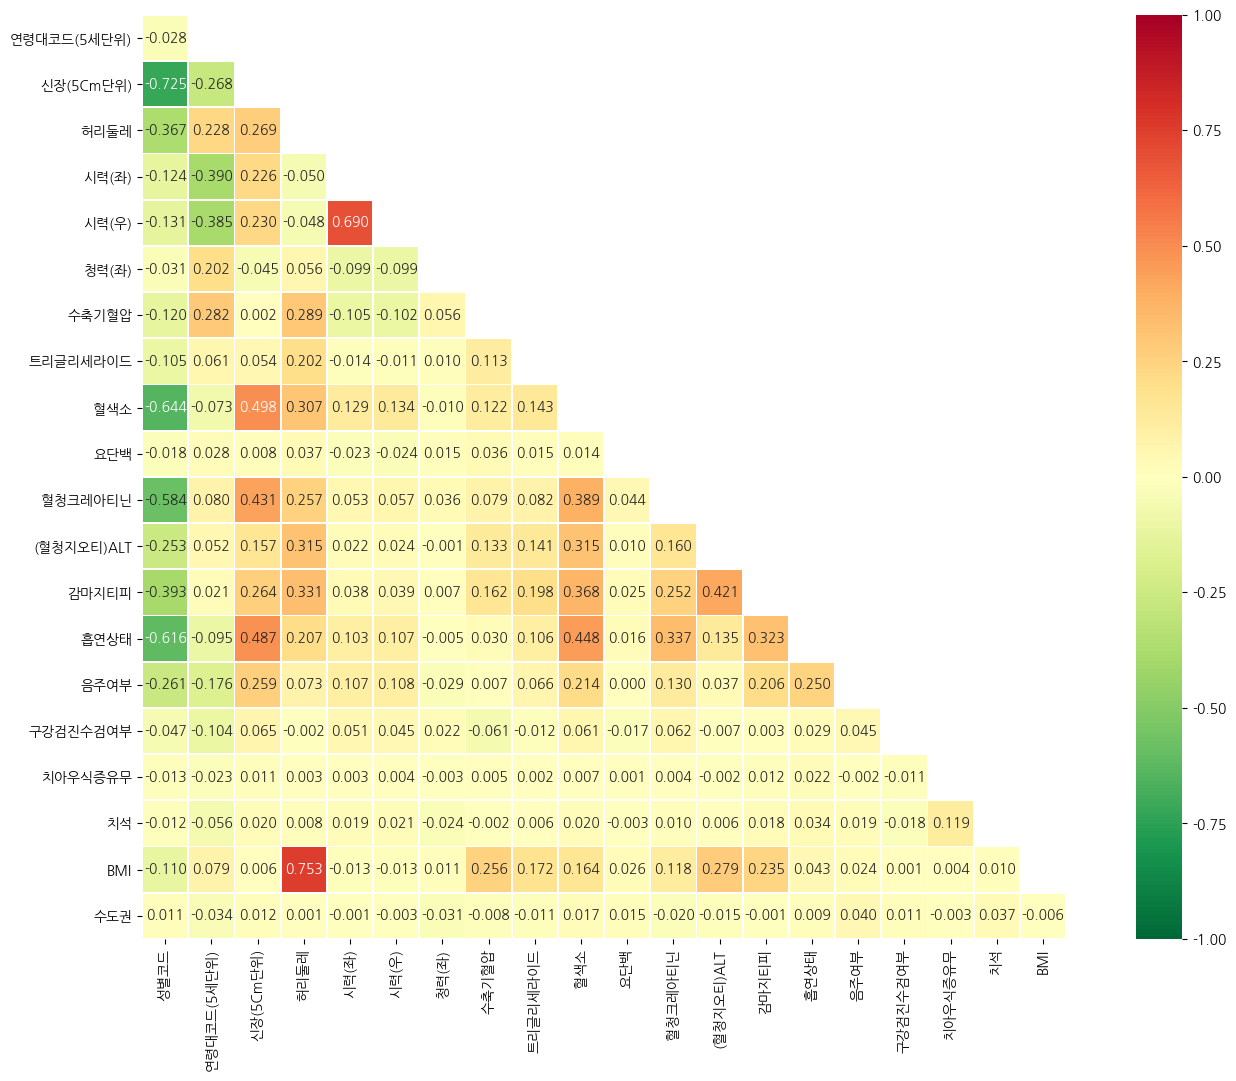

<Figure size 640x480 with 0 Axes>

In [ ]:
sns.reset_defaults()
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
corr_table = X.drop(columns='const').corr('pearson')
mask = np.zeros_like(corr_table)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(18,12))
ax = sns.heatmap(corr_table.iloc[1:, :-1], mask=mask[1:, :-1], cmap = 'RdYlGn_r', vmax = 1.0, vmin= -1.0, square=True, 
                 linewidth=.5, annot=True, fmt='.3f')
plt.show()
plt.clf()

***
# 5. 결과 해석 및 결론
#### 해석
- BMI, 요단백이 다른 변수들에 비해 특히 당뇨와 높은 상관관계를 보였다.
- 직관적으로 당뇨와 양의 상관관계가 있을 법한 변수(__BMI, 연령대, 허리둘레, 혈압, 흡연상태, 감마지티피, 혈청지오티 등__)들은 실제 결과에서도 당뇨와 양의 상관관계를 보였다.
- 치석, 혈색소 또한 사전 배경지식 조사단계에서 예측한 것과 비슷한(__or 다른__) 양상을 확인할 수 있다.(__조사한 논문들__)
- 특히, 시력이 낮고 남자이며 비수도권에 살수록 혈당수치가 높다는 결과는 흥미로웠다. 이와 관련된 연구들에서는 __다음과 같은 결과를 보고했다__ _구강검진수검여부(__빼도 좋을듯__)_

#### 결론
- 이후 당뇨병 예측 모델을 훈련시킬 때, 분석 결과에서 혈당수치와 큰 상관관계를 보인 변수들을 잘 활용해야겠다.